<a href="https://colab.research.google.com/github/vasusharma7/Machine-Learning/blob/master/pytorch_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/jonas-koehler/s2cnn.git
!git clone https://github.com/AMLab-Amsterdam/lie_learn.git
import requests  
file_url = "https://drive.google.com/uc?export=download&confirm=gFeQ&id=0B5e7DAOiLEZwSkdfXzBYT29Nc3c"
    
r = requests.get(file_url, stream = True)  
  
with open("lie_learn/lie_learn/representations/SO3/pinchon_hoggan/J_dense_0-278.npy", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)  

Cloning into 's2cnn'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 800 (delta 6), reused 10 (delta 4), pack-reused 775
Receiving objects: 100% (800/800), 944.62 KiB | 26.24 MiB/s, done.
Resolving deltas: 100% (418/418), done.
Cloning into 'lie_learn'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 335 (delta 13), reused 15 (delta 6), pack-reused 299
Receiving objects: 100% (335/335), 206.10 KiB | 14.72 MiB/s, done.
Resolving deltas: 100% (185/185), done.


In [3]:
%cd s2cnn
!python setup.py install
%cd ../lie_learn
!python setup.py install
%cd ..
!pip install pynvrtc joblib

/content/s2cnn
running install
running bdist_egg
running egg_info
creating s2cnn.egg-info
writing s2cnn.egg-info/PKG-INFO
writing dependency_links to s2cnn.egg-info/dependency_links.txt
writing top-level names to s2cnn.egg-info/top_level.txt
writing manifest file 's2cnn.egg-info/SOURCES.txt'
writing manifest file 's2cnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/s2cnn
copying s2cnn/so3_ft.py -> build/lib/s2cnn
copying s2cnn/so3_grid.py -> build/lib/s2cnn
copying s2cnn/so3_mm.py -> build/lib/s2cnn
copying s2cnn/s2_grid.py -> build/lib/s2cnn
copying s2cnn/s2_ft.py -> build/lib/s2cnn
copying s2cnn/s2_mm.py -> build/lib/s2cnn
copying s2cnn/__init__.py -> build/lib/s2cnn
creating build/lib/s2cnn/soft
copying s2cnn/soft/so3_integrate.py -> build/lib/s2cnn/soft
copying s2cnn/soft/so3_fft.py -> build/lib/s2cnn/soft
copying s2cnn/soft/so3_rotation.py -> build/lib/s2cnn/so

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='/home/CIFAR-10 Classifier Using CNN in PyTorch/data/', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:03, 42918352.34it/s]                               


Extracting /home/CIFAR-10 Classifier Using CNN in PyTorch/data/cifar-10-python.tar.gz to /home/CIFAR-10 Classifier Using CNN in PyTorch/data/


0it [00:00, ?it/s]

170500096it [00:04, 42419777.32it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
train_images = []
train_labels = []
test_images = []
test_labels = []
for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            train_images.append(inputs)
            train_labels.append(labels)

for i, data in enumerate(testloader, 0):
            # get the inputs
            inputs, labels = data
            test_images.append(inputs)
            test_labels.append(labels)
                        

In [0]:
cifar_train = {}
cifar_test = {}
cifar_train['images'] = torch.stack(train_images).permute(0,3,4,2,1).numpy()
cifar_train['labels'] = torch.stack(train_labels).numpy()
cifar_test['labels'] = torch.stack(test_labels).numpy()
cifar_test['images'] = torch.stack(test_images).permute(0,3,4,2,1).numpy()
cifar_test['images'] = cifar_test['images'].reshape(10000,32,32,3)
cifar_train['images'] = cifar_train['images'].reshape(50000,32,32,3)
cifar_test['labels'] = cifar_test['labels'].reshape(10000)
cifar_train['labels'] = cifar_train['labels'].reshape(50000)

In [0]:
import numpy as np
def grayscale(images):
  def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870,0.1140])
  gray = []
  for image in images:
    gray.append(rgb2gray(image))
  return   np.array(gray)


In [0]:
cifar_train['images'] = grayscale(cifar_train['images'])
cifar_test['images'] = grayscale(cifar_test['images'])


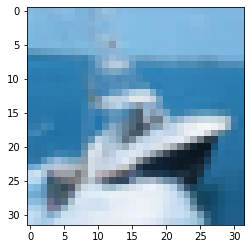

In [12]:
# cifar_test['images'][0]
from matplotlib import pyplot as plt
plt.imshow(train_images[8].reshape(3,32,32).permute(1,2,0).numpy())
plt.show()

In [13]:
'''Module to generate the spherical cifar data set'''
%cd /content
import gzip
import pickle
from pprint import pprint
import numpy as np
import argparse
import torch
import lie_learn.spaces.S2 as S2
from torchvision import datasets
from sklearn import preprocessing
import torchvision.transforms as transforms
NORTHPOLE_EPSILON = 1e-3


def rand_rotation_matrix(deflection=1.0, randnums=None):
    """
    Creates a random rotation matrix.

    deflection: the magnitude of the rotation. For 0, no rotation; for 1, competely random
    rotation. Small deflection => small perturbation.
    randnums: 3 random numbers in the range [0, 1]. If `None`, they will be auto-generated.

    # http://blog.lostinmyterminal.com/python/2015/05/12/random-rotation-matrix.html
    """

    if randnums is None:
        randnums = np.random.uniform(size=(3,))

    theta, phi, z = randnums

    theta = theta * 2.0*deflection*np.pi  # Rotation about the pole (Z).
    phi = phi * 2.0*np.pi  # For direction of pole deflection.
    z = z * 2.0*deflection  # For magnitude of pole deflection.

    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.

    r = np.sqrt(z)
    V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z)
    )

    st = np.sin(theta)
    ct = np.cos(theta)

    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))

    # Construct the rotation matrix  ( V Transpose(V) - I ) R.

    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M


def rotate_grid(rot, grid):
    x, y, z = grid
    xyz = np.array((x, y, z))
    x_r, y_r, z_r = np.einsum('ij,jab->iab', rot, xyz)
    return x_r, y_r, z_r


def get_projection_grid(b, grid_type="Driscoll-Healy"):
    ''' returns the spherical grid in euclidean
    coordinates, where the sphere's center is moved
    to (0, 0, 1)'''
    theta, phi = S2.meshgrid(b=b, grid_type=grid_type)
    x_ = np.sin(theta) * np.cos(phi)
    y_ = np.sin(theta) * np.sin(phi)
    z_ = np.cos(theta)
    return x_, y_, z_


def project_sphere_on_xy_plane(grid, projection_origin):
    ''' returns xy coordinates on the plane
    obtained from projecting each point of
    the spherical grid along the ray from
    the projection origin through the sphere '''

    sx, sy, sz = projection_origin
    x, y, z = grid
    z = z.copy() + 1

    t = -z / (z - sz)
    qx = t * (x - sx) + x
    qy = t * (y - sy) + y

    xmin = 1/2 * (-1 - sx) + -1
    ymin = 1/2 * (-1 - sy) + -1

    # ensure that plane projection
    # ends up on southern hemisphere
    rx = (qx - xmin) / (2 * np.abs(xmin))
    ry = (qy - ymin) / (2 * np.abs(ymin))

    return rx, ry


def sample_within_bounds(signal, x, y, bounds):
    ''' '''
    xmin, xmax, ymin, ymax = bounds

    idxs = (xmin <= x) & (x < xmax) & (ymin <= y) & (y < ymax)

    if len(signal.shape) > 2:
        sample = np.zeros((signal.shape[0], x.shape[0], x.shape[1]))
        sample[:, idxs] = signal[:, x[idxs], y[idxs]]
    else:
        sample = np.zeros((x.shape[0], x.shape[1]))
        sample[idxs] = signal[x[idxs], y[idxs]]
    return sample


def sample_bilinear(signal, rx, ry):
    ''' '''

    signal_dim_x = signal.shape[1]
    signal_dim_y = signal.shape[2]

    rx *= signal_dim_x
    ry *= signal_dim_y

    # discretize sample position
    ix = rx.astype(int)
    iy = ry.astype(int)

    # obtain four sample coordinates
    ix0 = ix - 1
    iy0 = iy - 1
    ix1 = ix + 1
    iy1 = iy + 1

    bounds = (0, signal_dim_x, 0, signal_dim_y)

    # sample signal at each four positions
    signal_00 = sample_within_bounds(signal, ix0, iy0, bounds)
    signal_10 = sample_within_bounds(signal, ix1, iy0, bounds)
    signal_01 = sample_within_bounds(signal, ix0, iy1, bounds)
    signal_11 = sample_within_bounds(signal, ix1, iy1, bounds)

    # linear interpolation in x-direction
    fx1 = (ix1-rx) * signal_00 + (rx-ix0) * signal_10
    fx2 = (ix1-rx) * signal_01 + (rx-ix0) * signal_11

    # linear interpolation in y-direction
    return (iy1 - ry) * fx1 + (ry - iy0) * fx2


def project_2d_on_sphere(signal, grid, projection_origin=None):
    ''' '''
    if projection_origin is None:
        projection_origin = (0, 0, 2 + NORTHPOLE_EPSILON)

    rx, ry = project_sphere_on_xy_plane(grid, projection_origin)
    sample = sample_bilinear(signal, rx, ry)

    # ensure that only south hemisphere gets projected
    sample *= (grid[2] <= 1).astype(np.float64)

    # rescale signal to [0,1]
    sample_min = sample.min(axis=(1, 2)).reshape(-1, 1, 1)
    sample_max = sample.max(axis=(1, 2)).reshape(-1, 1, 1)

    sample = (sample - sample_min) / (sample_max - sample_min)
    sample *= 255
    sample = sample.astype(np.uint8)

    return sample

def main():
    args = {}
    args['bandwidth'] = 30
    args['chunk_size'] = 1
    args['noise'] = 1
    args['chunk_size'] = 1
    args['cifar_data_folder'] = "CIFAR_data"
    args['mnist_data_folder'] = "MNIST_data"
    args['output_file'] = "s2_cifar.gz"
    args['no_rotate_train'] = True
    args['no_rotate_test'] = True

    grid = get_projection_grid(b=args['bandwidth'])
    # result
    dataset = {}

    no_rotate = {"train": args["no_rotate_train"], "test": args["no_rotate_test"]}

    for label, data in zip(["train", "test"], [cifar_train, cifar_test]):

        print("projecting {0} data set".format(label))
        current = 0
        signals = data['images'].reshape(-1, 32, 32).astype(np.float64)
        n_signals = signals.shape[0]
        projections = np.ndarray(
            (signals.shape[0], 2 * args["bandwidth"], 2 * args["bandwidth"]),
            dtype=np.uint8)

        while current < n_signals:

            if not no_rotate[label]:
                rot = rand_rotation_matrix(deflection=args["noise"])
                rotated_grid = rotate_grid(rot, grid)
            else:
                rotated_grid = grid

            idxs = np.arange(current, min(n_signals,
                                          current + args["chunk_size"]))
            chunk = signals[idxs]
            projections[idxs] = project_2d_on_sphere(chunk, rotated_grid)
            current += args["chunk_size"]
            print("\r{0}/{1}".format(current, n_signals), end="")
        print("")

        dataset[label] = {
            'images': projections,
            'labels': data['labels']
        }
    print("writing pickle")
    with gzip.open(args["output_file"], 'wb') as f:
        pickle.dump(dataset, f)
    print("done")


if __name__ == '__main__':
    main()

/content
projecting train data set
50000/50000
projecting test data set
10000/10000
writing pickle
done


SAVE THE CODE IN THE BELOW CELL IN CIFAF10 FOLDER LOCATED IN S2CNN/EXAMPLES AS '.py' FILE AND THEN RUN THE FILE AS !python run.py
THIS IS DONE BECAUSE THE CODE IS UNABLE TO GET THE REQUIRED s2cnn MODULES WHEN RUN IN THE CELLS

In [0]:
# pylint: disable=E1101,R,C
import numpy as np
import torch.nn as nn
from s2cnn import SO3Convolution
from s2cnn import S2Convolution
from s2cnn import so3_integrate
from s2cnn import so3_near_identity_grid
from s2cnn import s2_near_identity_grid
import torch.nn.functional as F
import torch
import torch.utils.data as data_utils
import gzip
import pickle
import numpy as np
from torch.autograd import Variable
import argparse

MNIST_PATH = "s2_cifar.gz"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NUM_EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 5e-3


def load_data(path, batch_size):

    with gzip.open(path, 'rb') as f:
        dataset = pickle.load(f)

    train_data = torch.from_numpy(
        dataset["train"]["images"][:, None, :, :].astype(np.float32))
    train_labels = torch.from_numpy(
        dataset["train"]["labels"].astype(np.int64))

    # TODO normalize dataset
    # mean = train_data.mean()
    # stdv = train_data.std()

    train_dataset = data_utils.TensorDataset(train_data, train_labels)
    train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_data = torch.from_numpy(
        dataset["test"]["images"][:, None, :, :].astype(np.float32))
    test_labels = torch.from_numpy(
        dataset["test"]["labels"].astype(np.int64))

    test_dataset = data_utils.TensorDataset(test_data, test_labels)
    test_loader = data_utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader, train_dataset, test_dataset


class S2ConvNet_original(nn.Module):

    def __init__(self):
        super(S2ConvNet_original, self).__init__()

        f1 = 20
        f2 = 40
        f_output = 10

        b_in = 30
        b_l1 = 10
        b_l2 = 6

        grid_s2 = s2_near_identity_grid()
        grid_so3 = so3_near_identity_grid()

        self.conv1 = S2Convolution(
            nfeature_in=1,
            nfeature_out=f1,
            b_in=b_in,
            b_out=b_l1,
            grid=grid_s2)

        self.conv2 = SO3Convolution(
            nfeature_in=f1,
            nfeature_out=f2,
            b_in=b_l1,
            b_out=b_l2,
            grid=grid_so3)

        self.out_layer = nn.Linear(f2, f_output)

    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)

        x = so3_integrate(x)

        x = self.out_layer(x)

        return x


class S2ConvNet_deep(nn.Module):

    def __init__(self, bandwidth=30):
        super(S2ConvNet_deep, self).__init__()

        grid_s2    =  s2_near_identity_grid(n_alpha=6, max_beta=np.pi/16, n_beta=1)
        grid_so3_1 = so3_near_identity_grid(n_alpha=6, max_beta=np.pi/16, n_beta=1, max_gamma=2*np.pi, n_gamma=6)
        grid_so3_2 = so3_near_identity_grid(n_alpha=6, max_beta=np.pi/ 8, n_beta=1, max_gamma=2*np.pi, n_gamma=6)
        grid_so3_3 = so3_near_identity_grid(n_alpha=6, max_beta=np.pi/ 4, n_beta=1, max_gamma=2*np.pi, n_gamma=6)
        grid_so3_4 = so3_near_identity_grid(n_alpha=6, max_beta=np.pi/ 2, n_beta=1, max_gamma=2*np.pi, n_gamma=6)

        self.convolutional = nn.Sequential(
            S2Convolution(
                nfeature_in  = 1,
                nfeature_out = 8,
                b_in  = bandwidth,
                b_out = bandwidth,
                grid=grid_s2),
            nn.ReLU(inplace=False),
            SO3Convolution(
                nfeature_in  =  8,
                nfeature_out = 16,
                b_in  = bandwidth,
                b_out = bandwidth//2,
                grid=grid_so3_1),
            nn.ReLU(inplace=False),

            SO3Convolution(
                nfeature_in  = 16,
                nfeature_out = 16,
                b_in  = bandwidth//2,
                b_out = bandwidth//2,
                grid=grid_so3_2),
            nn.ReLU(inplace=False),
            SO3Convolution(
                nfeature_in  = 16,
                nfeature_out = 24,
                b_in  = bandwidth//2,
                b_out = bandwidth//4,
                grid=grid_so3_2),
            nn.ReLU(inplace=False),

            SO3Convolution(
                nfeature_in  = 24,
                nfeature_out = 24,
                b_in  = bandwidth//4,
                b_out = bandwidth//4,
                grid=grid_so3_3),
            nn.ReLU(inplace=False),
            SO3Convolution(
                nfeature_in  = 24,
                nfeature_out = 32,
                b_in  = bandwidth//4,
                b_out = bandwidth//8,
                grid=grid_so3_3),
            nn.ReLU(inplace=False),

            SO3Convolution(
                nfeature_in  = 32,
                nfeature_out = 64,
                b_in  = bandwidth//8,
                b_out = bandwidth//8,
                grid=grid_so3_4),
            nn.ReLU(inplace=False)
            )

        self.linear = nn.Sequential(
            # linear 1
            nn.BatchNorm1d(64),
            nn.Linear(in_features=64,out_features=64),
            nn.ReLU(inplace=False),
            # linear 2
            nn.BatchNorm1d(64),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(inplace=False),
            # linear 3
            nn.BatchNorm1d(32),
            nn.Linear(in_features=32, out_features=10)
        )

    def forward(self, x):
        x = self.convolutional(x)
        x = so3_integrate(x)
        x = self.linear(x)
        return x



def main(network):

    train_loader, test_loader, train_dataset, _ = load_data(
        MNIST_PATH, BATCH_SIZE)

    if network == 'original':
        classifier = S2ConvNet_original()
    elif network == 'deep':
        classifier = S2ConvNet_deep()
    else:
        raise ValueError('Unknown network architecture')
    classifier.to(DEVICE)

    print("#params", sum(x.numel() for x in classifier.parameters()))

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(DEVICE)

    optimizer = torch.optim.Adam(
        classifier.parameters(),
        lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        for i, (images, labels) in enumerate(train_loader):
            classifier.train()

            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = classifier(images)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(
                epoch+1, NUM_EPOCHS, i+1, len(train_dataset)//BATCH_SIZE,
                loss.item()), end="")
        print("")
        correct = 0
        total = 0
        for images, labels in test_loader:

            classifier.eval()

            with torch.no_grad():
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = classifier(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).long().sum().item()

        print('Test Accuracy: {0}'.format(100 * correct / total))


if __name__ == '__main__':
    network = "deep" #deep\original

    main(network)


In [20]:
%cd /content/s2cnn/examples/
!mkdir cifar10
!cp /content/s2_cifar.gz cifar10/
%cd cifar10/
!python run.py

/content/s2cnn/examples
mkdir: cannot create directory ‘cifar10’: File exists
/content/s2cnn/examples/cifar10
#params 156882
compute 0.pkl.gz... save 0.pkl.gz... done
compute 0.pkl.gz... save 0.pkl.gz... done
compute 0.pkl.gz... save 0.pkl.gz... done
compute 1.pkl.gz... save 1.pkl.gz... done
compute 0.pkl.gz... save 0.pkl.gz... done
compute 2.pkl.gz... save 2.pkl.gz... done
compute 3.pkl.gz... save 3.pkl.gz... done
compute 1.pkl.gz... save 1.pkl.gz... done
compute 4.pkl.gz... save 4.pkl.gz... done
compute 2.pkl.gz... save 2.pkl.gz... done
compute 5.pkl.gz... save 5.pkl.gz... done
compute 6.pkl.gz... save 6.pkl.gz... done
compute 3.pkl.gz... save 3.pkl.gz... done
compute 7.pkl.gz... save 7.pkl.gz... done
compute 4.pkl.gz... save 4.pkl.gz... done
compute 8.pkl.gz... save 8.pkl.gz... done
compute 9.pkl.gz... save 9.pkl.gz... done
compute 5.pkl.gz... save 5.pkl.gz... done
Epoch [1/20], Iter [1563/1562] Loss: 1.4845
Test Accuracy: 29.87
Epoch [2/20], Iter [1563/1562] Loss: 1.9222
Test Accur